In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


# **Step 1:** Fourier Transform on the First Row of the First Group of Data

In [23]:

# Assuming data is in columns like 'group1_1', 'group1_2', ..., 'group2_1', 'group2_2', etc.
data = pd.read_csv('F:\\UZH\\semester2\\spatial_analysis2\\assignment1\\dc-isc-lu-data.csv')

tweet_features = data.filter(regex='^tw_')
user_features = data.filter(regex='^user_')
entropy_features = data.filter(regex='^entropy_')

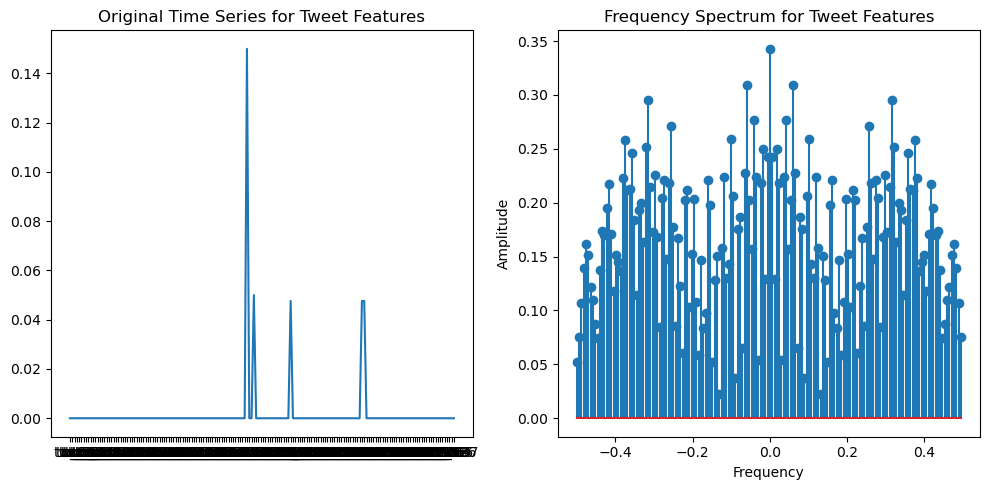

In [100]:
tweet_record = tweet_features.iloc[0, :]  # First row of the data

# Perform Fourier Transform
fft_values = np.fft.fft(tweet_record)
frequencies = np.fft.fftfreq(len(tweet_record))
plt.figure(figsize=(10, 5))

# Time series plot
plt.subplot(1, 2, 1)
plt.plot(tweet_record.index, tweet_record.values)
plt.title('Original Time Series for Tweet Features')

# Frequency spectrum plot
plt.subplot(1, 2, 2)
plt.stem(frequencies, np.abs(fft_values))
plt.title('Frequency Spectrum for Tweet Features')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


In [47]:
# Example for selecting the top N frequencies
N = 5  # Number of frequencies to retain
important_freqs = np.argsort(np.abs(fft_values))[-N:]
important_freqs.shape

(5,)

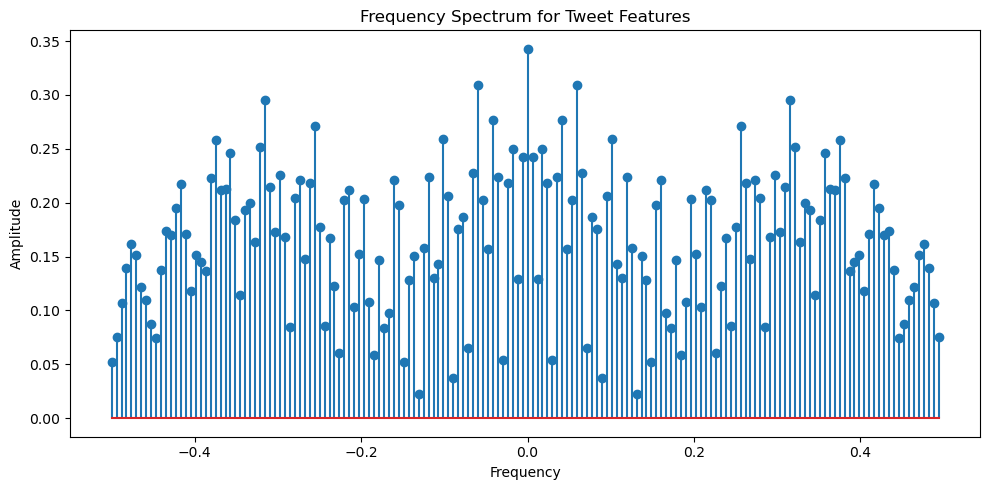

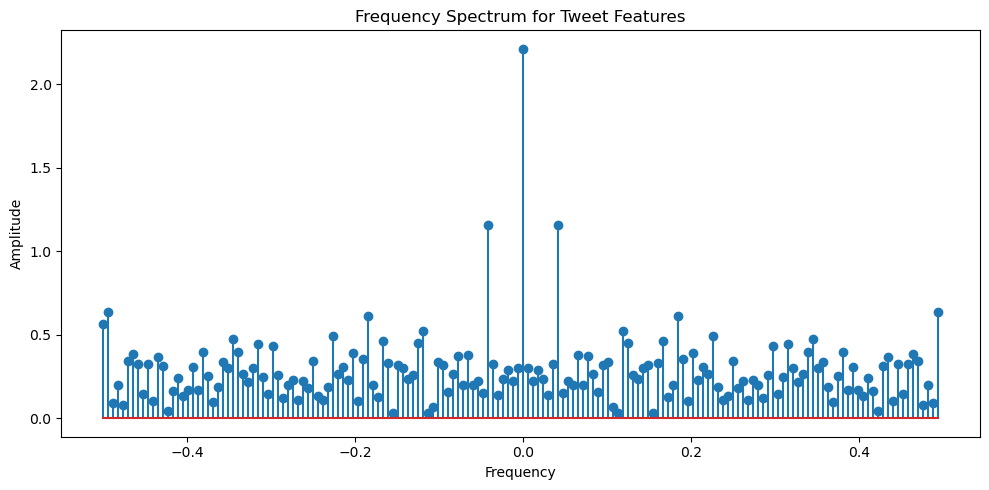

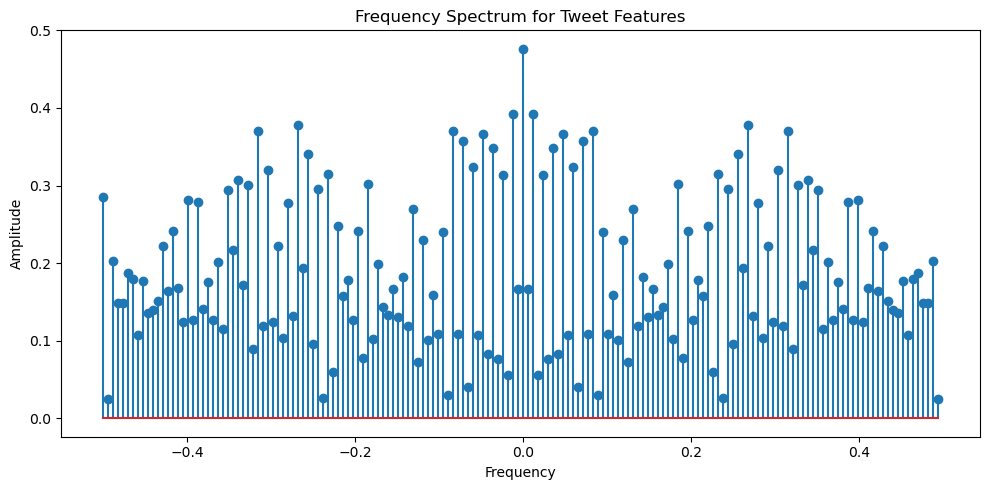

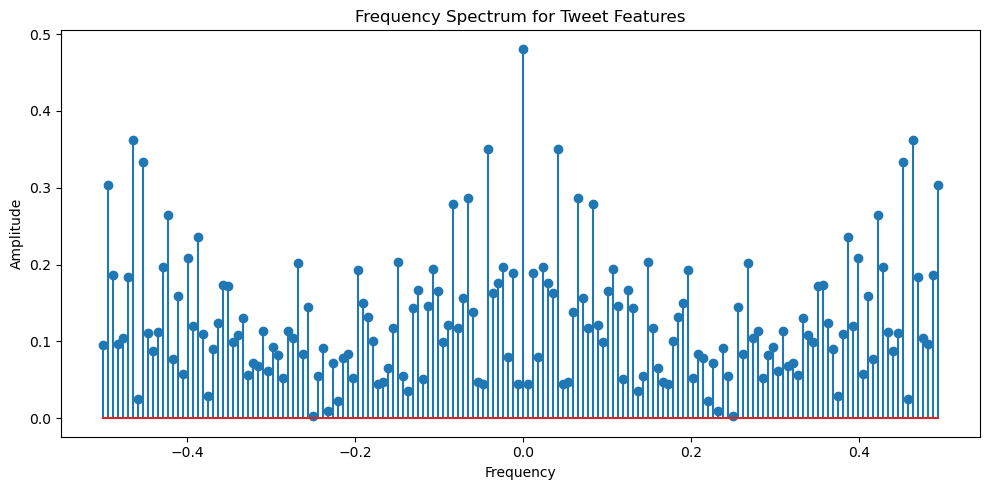

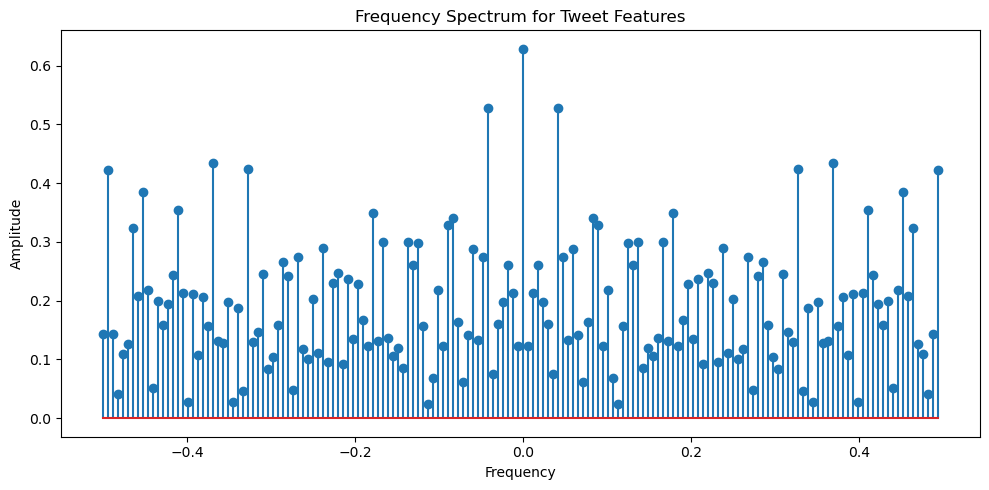

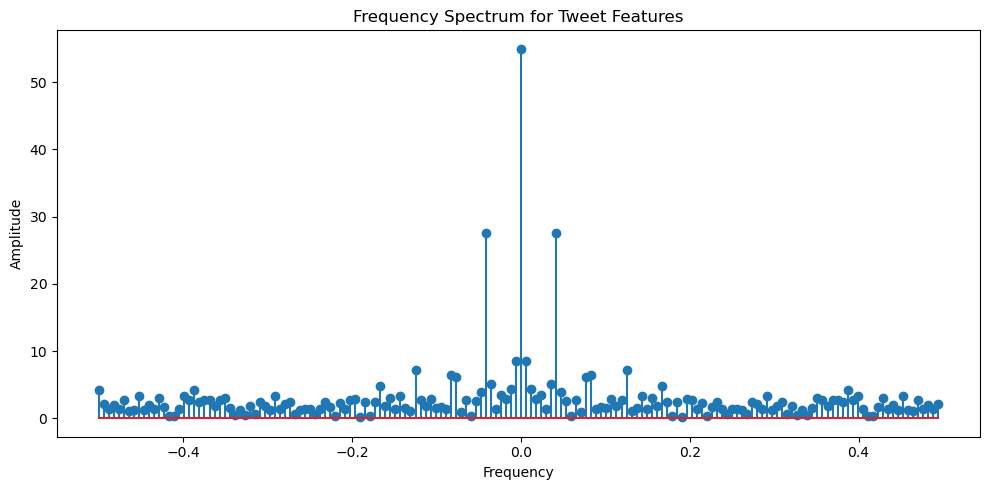

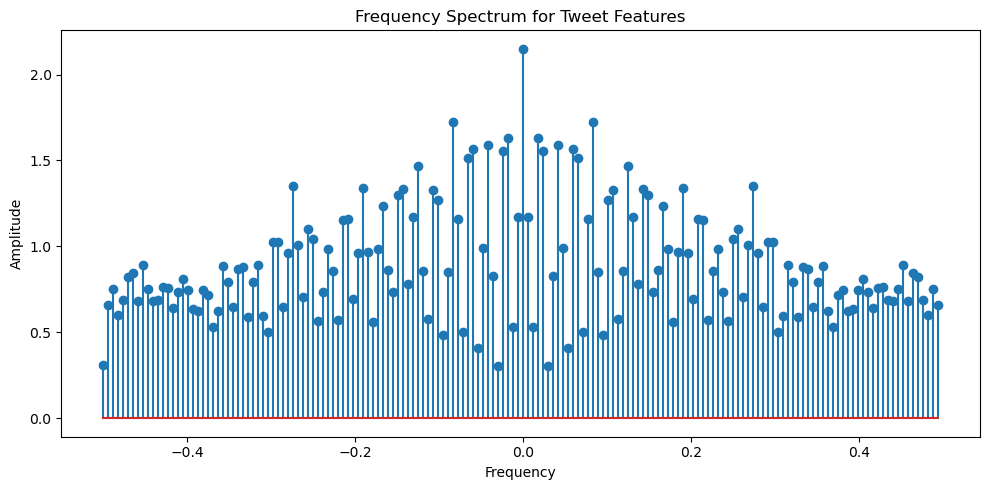

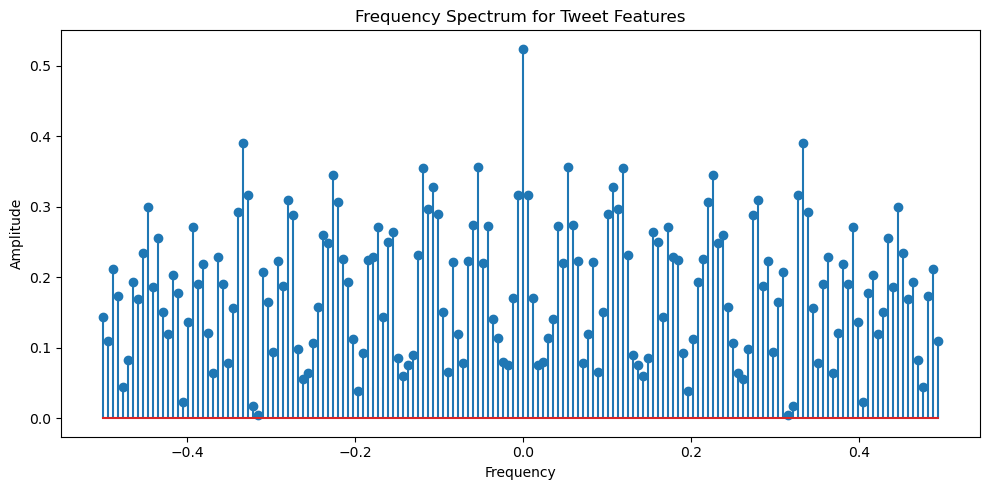

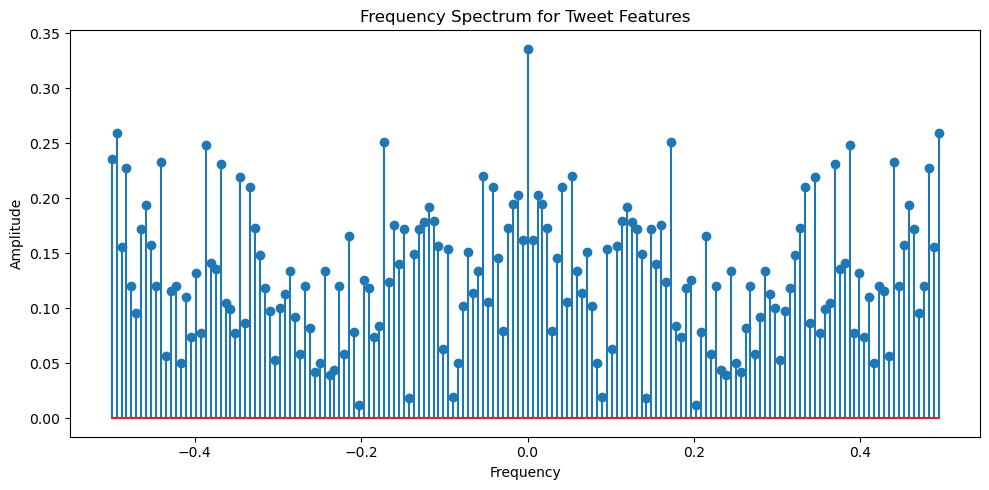

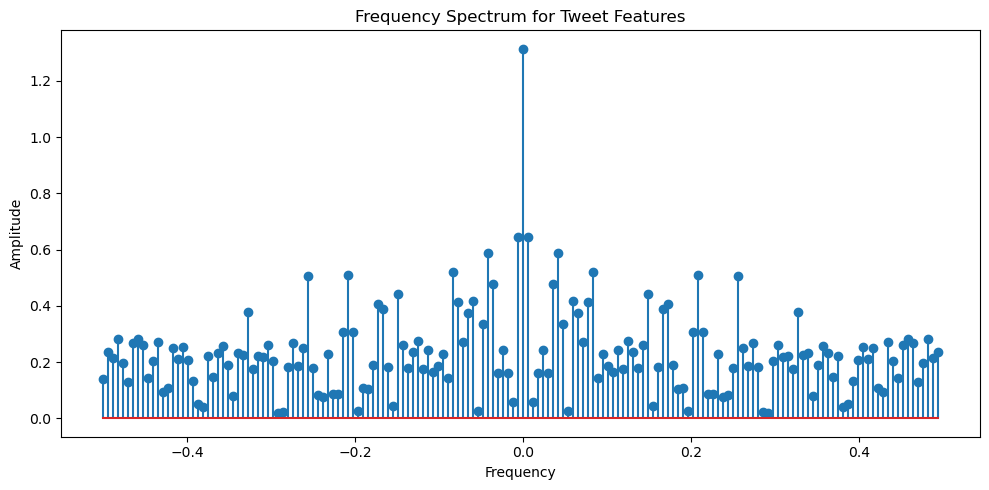

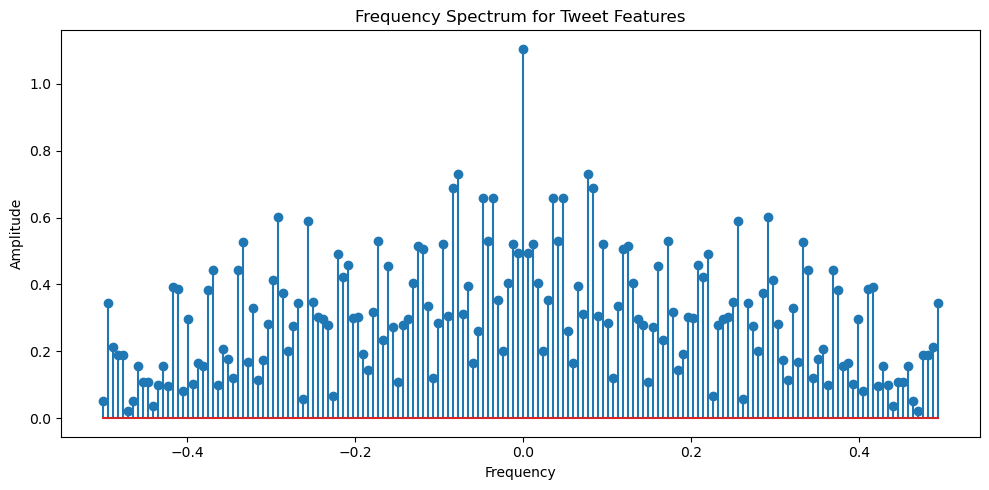

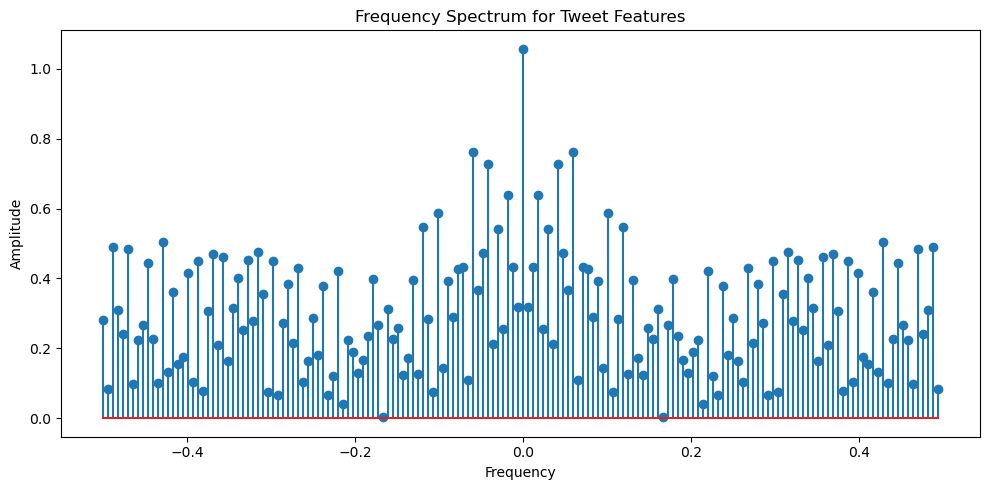

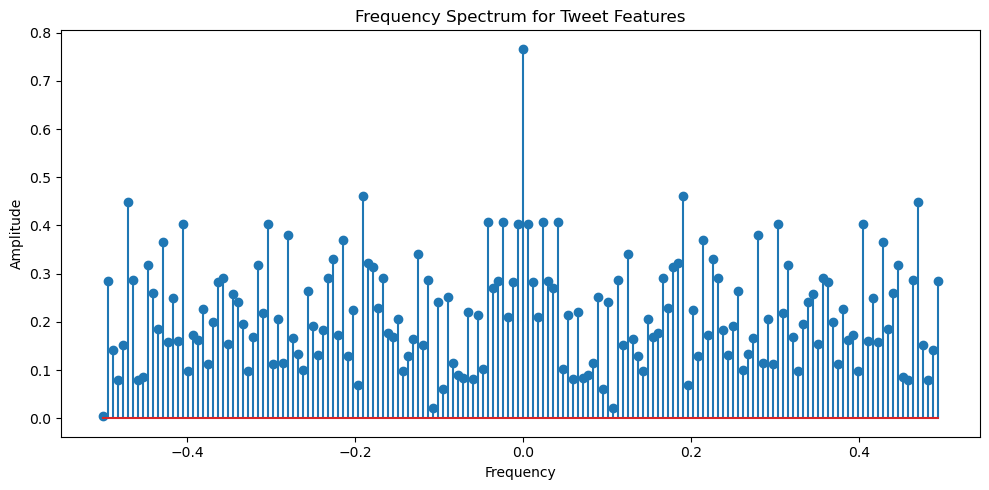

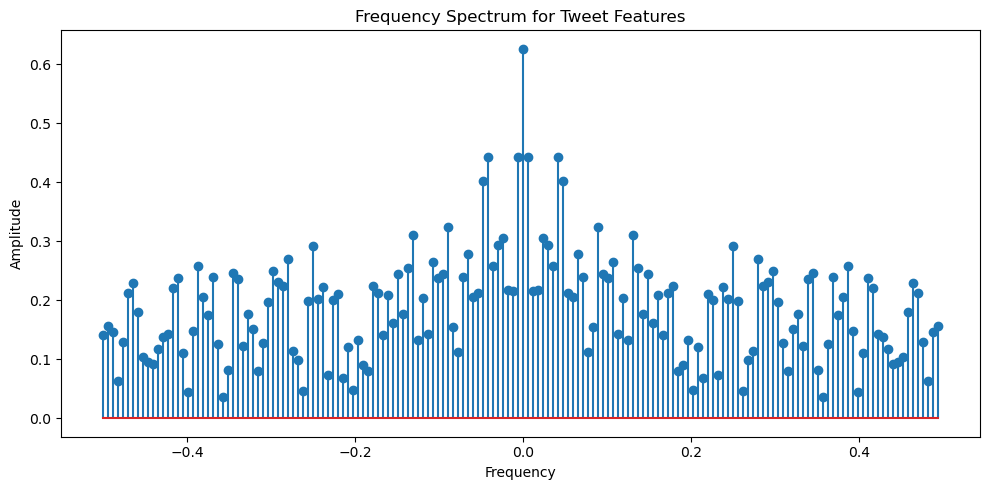

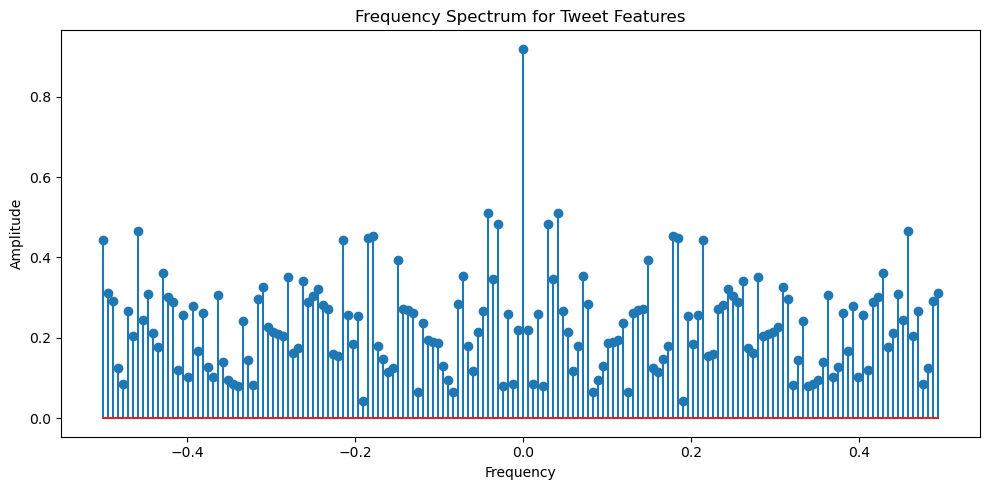

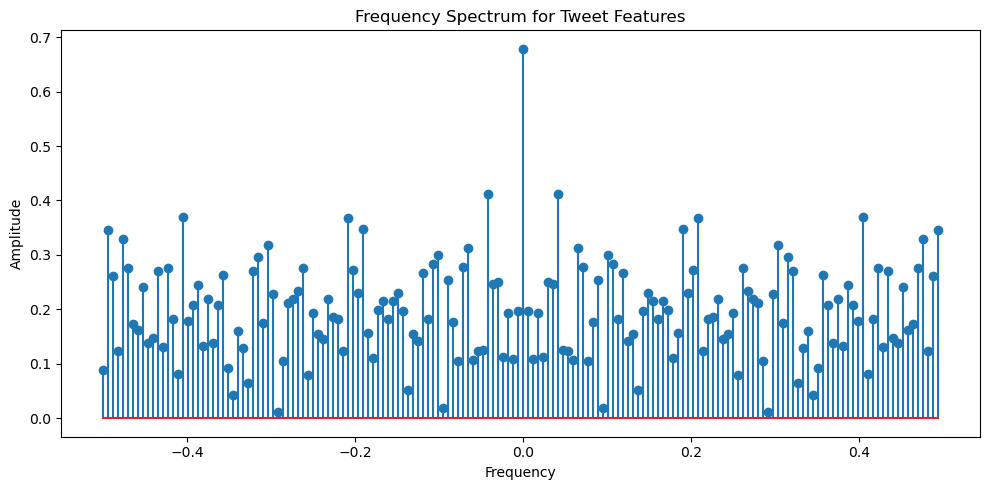

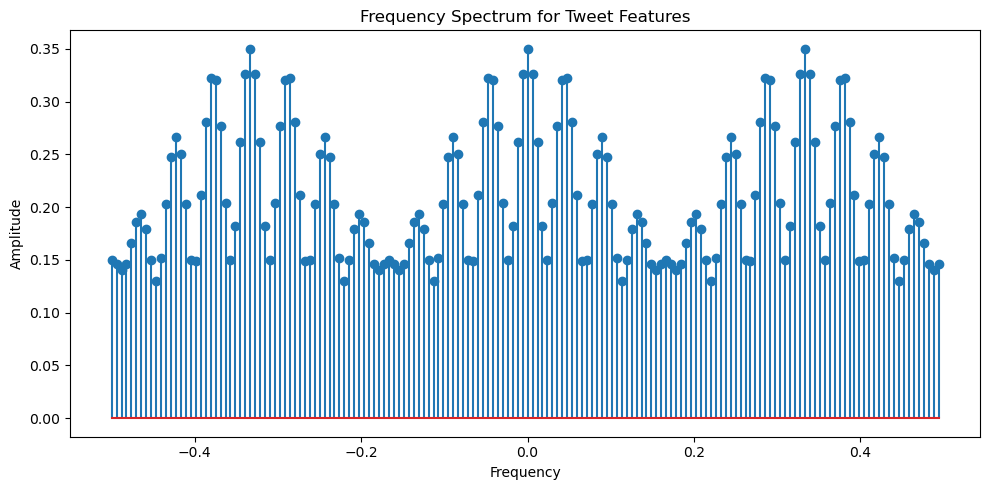

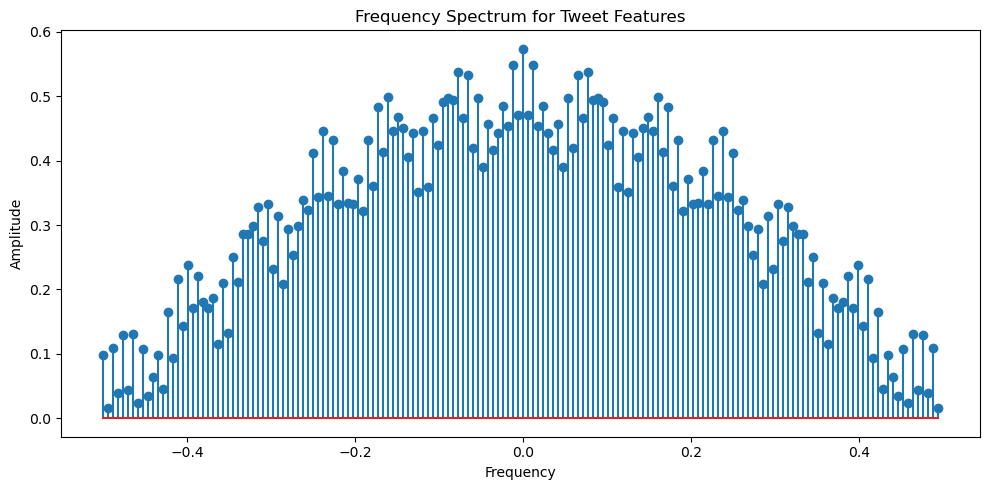

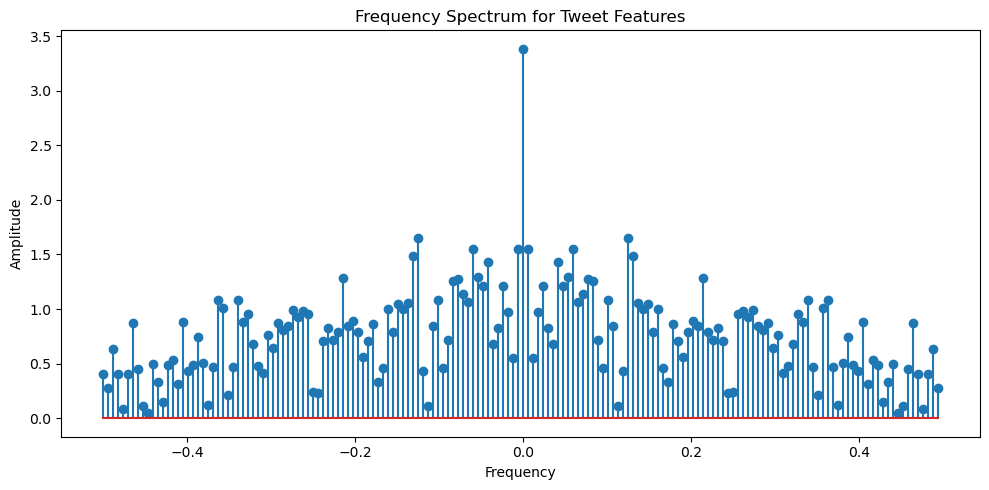

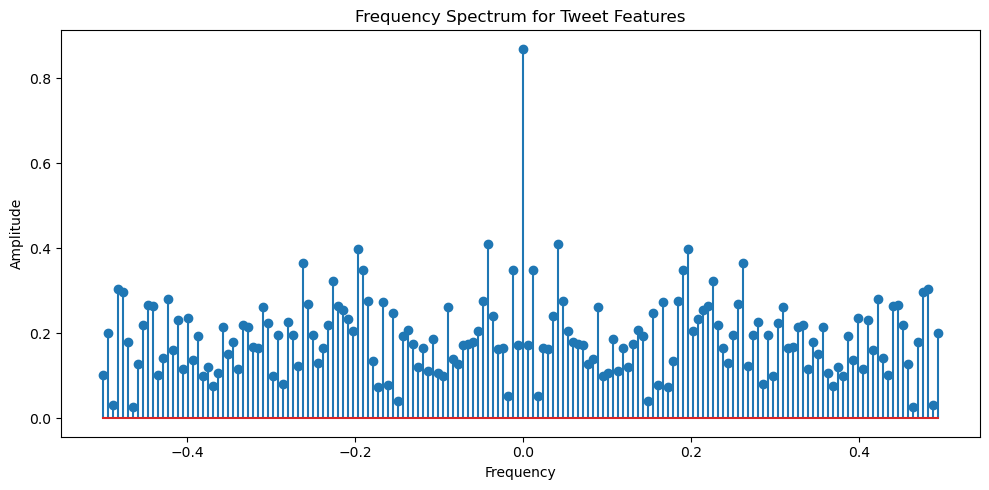

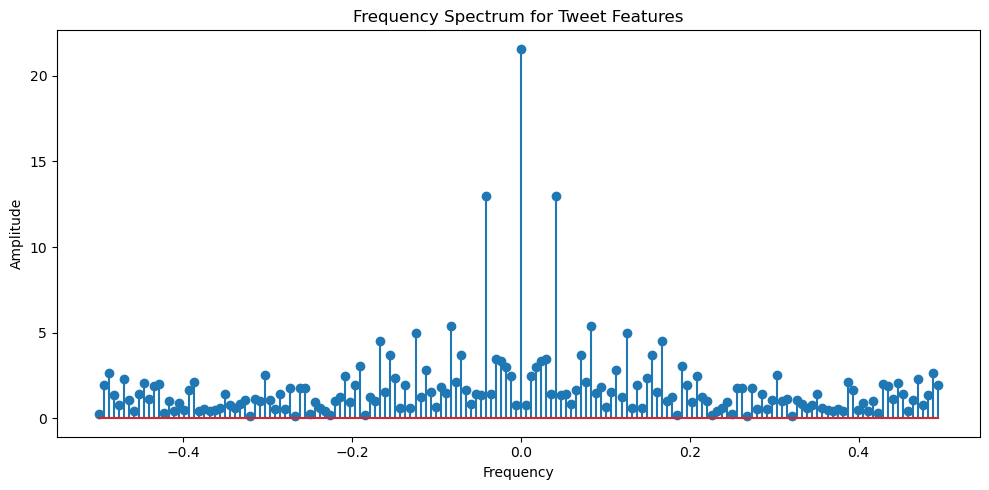

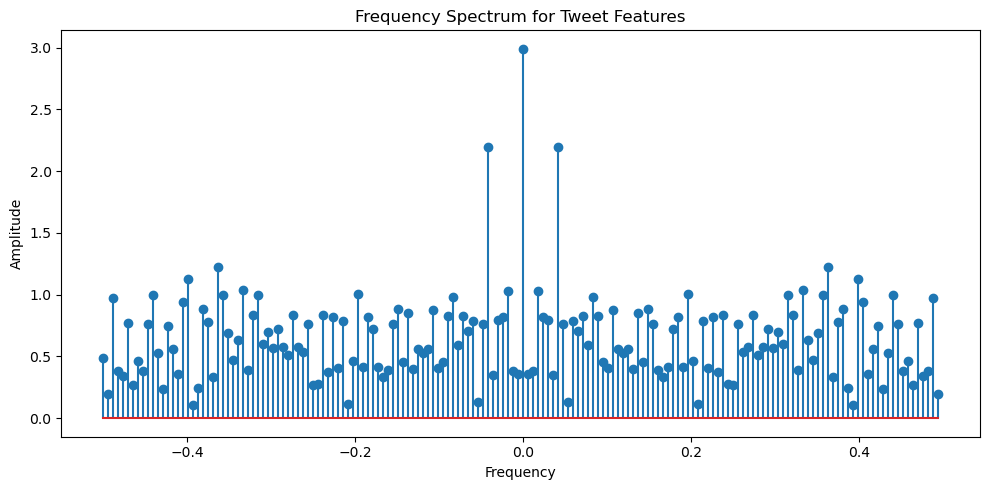

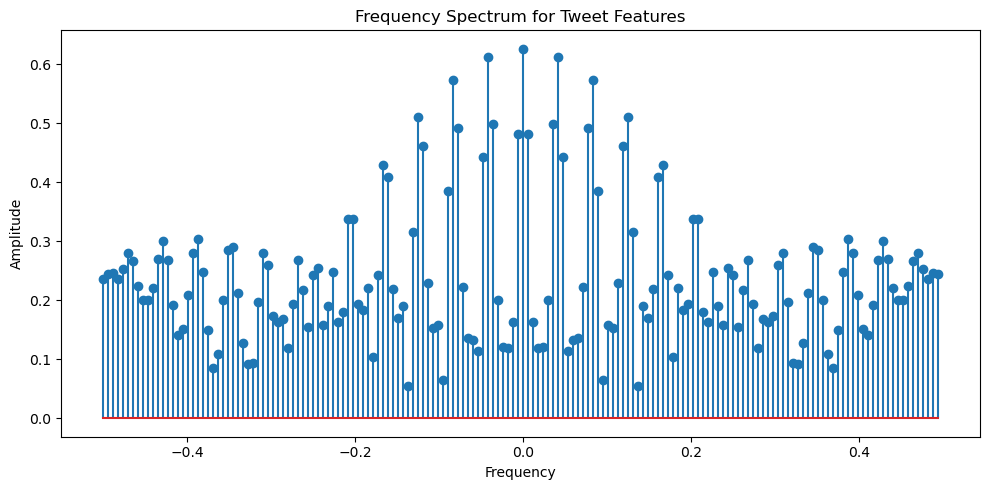

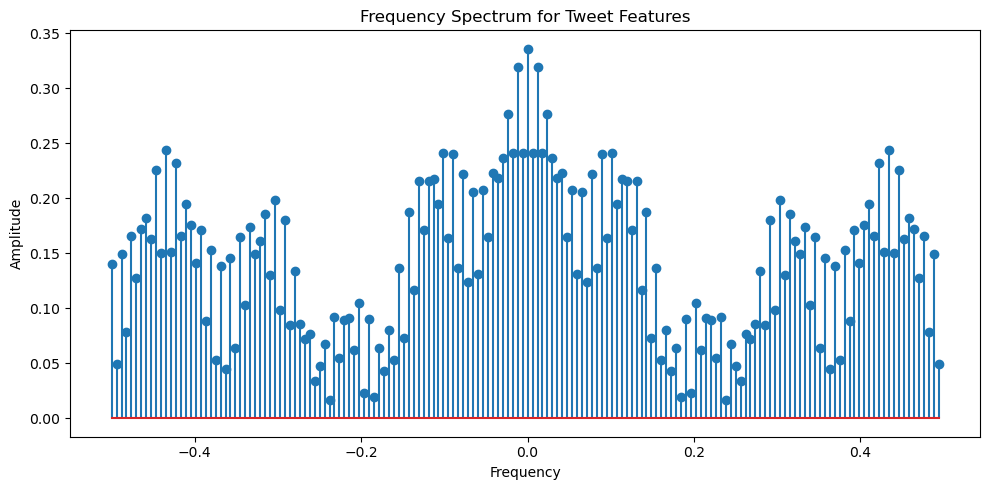

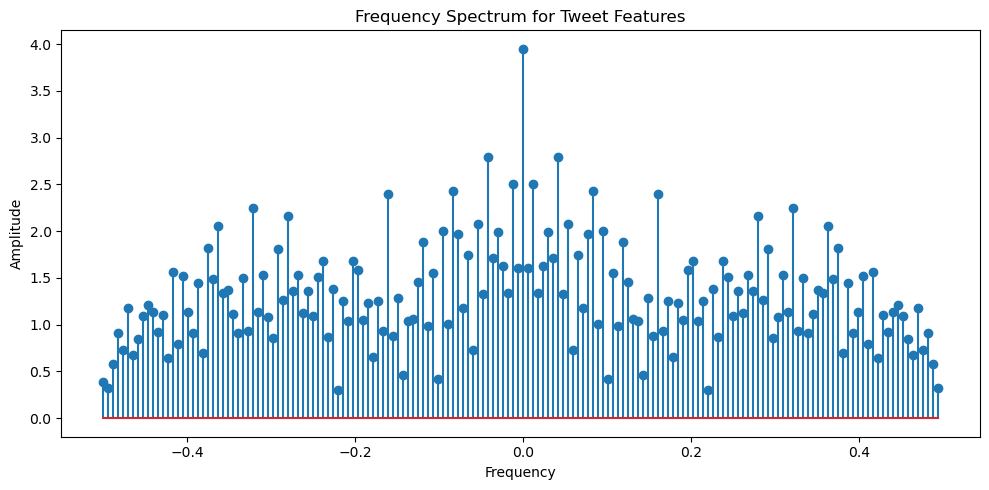

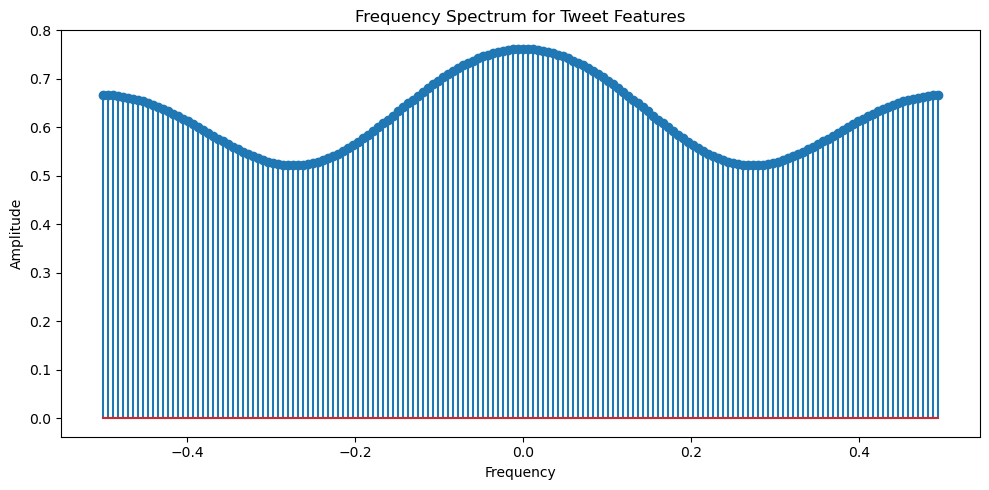

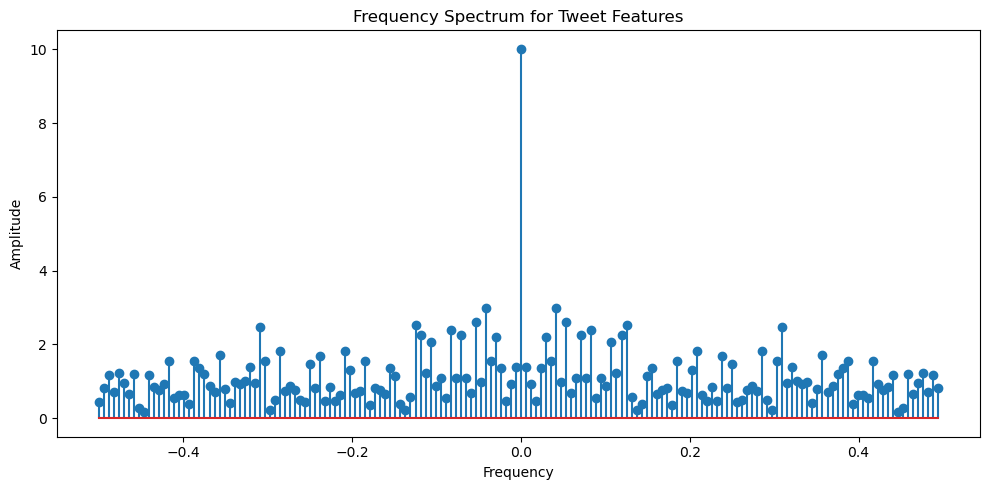

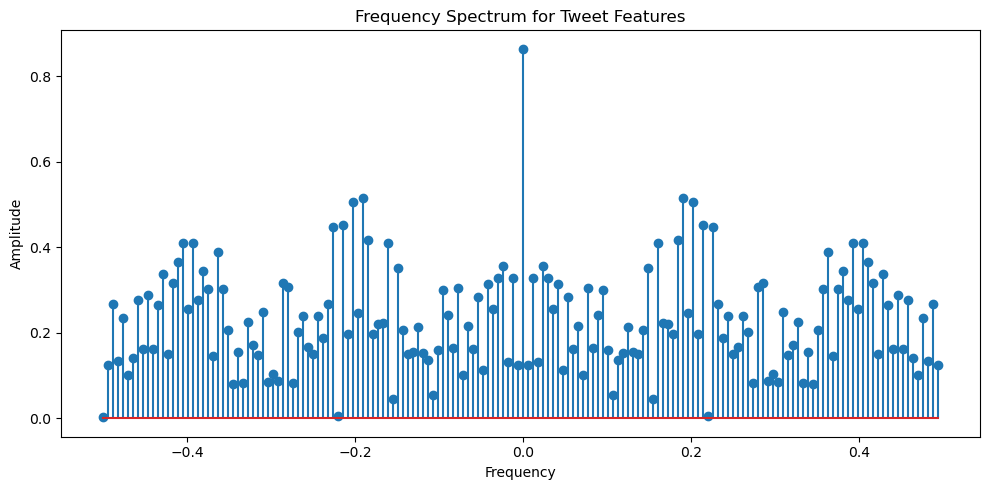

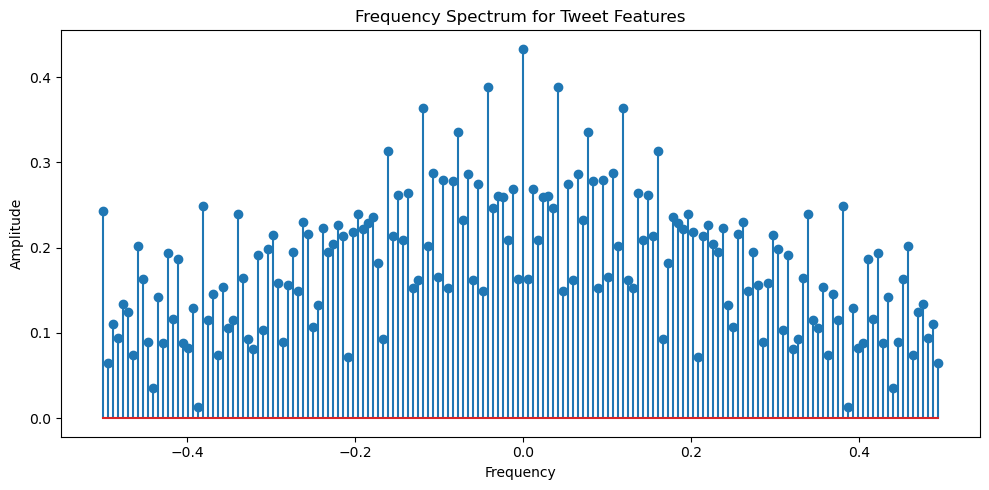

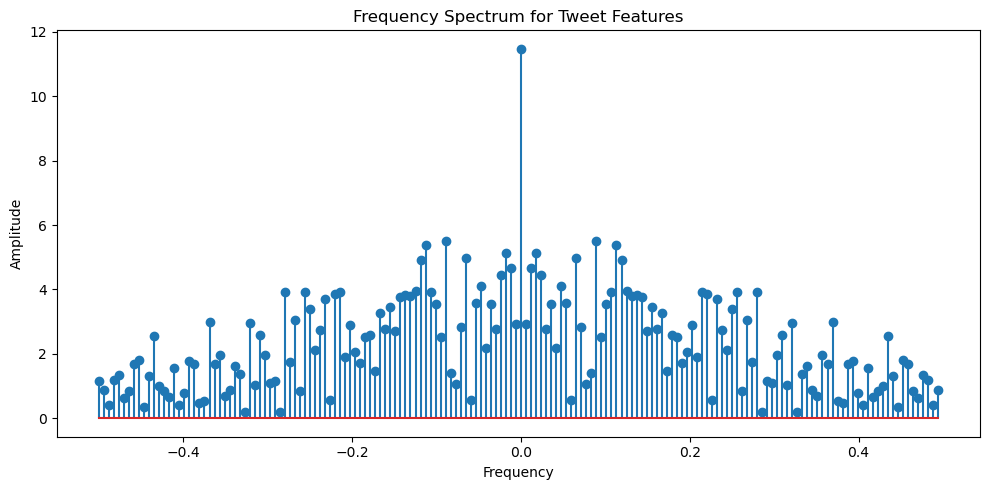

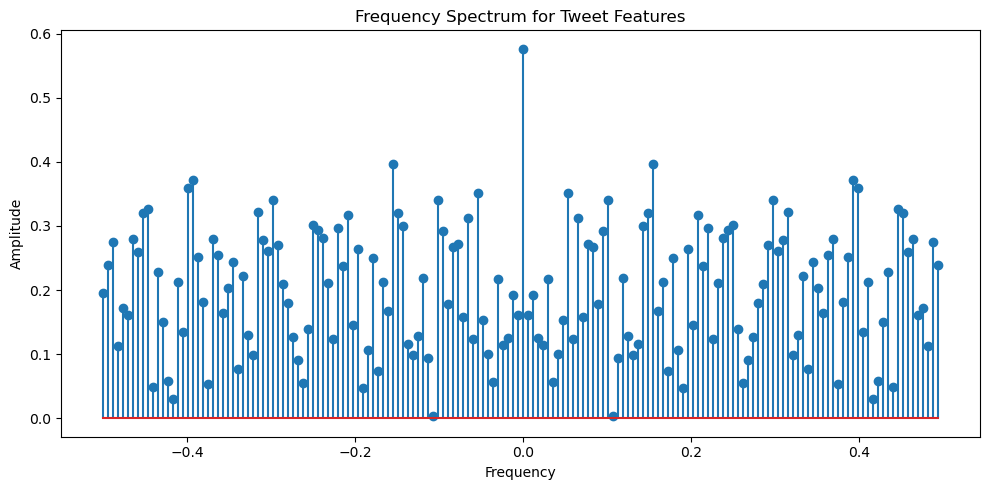

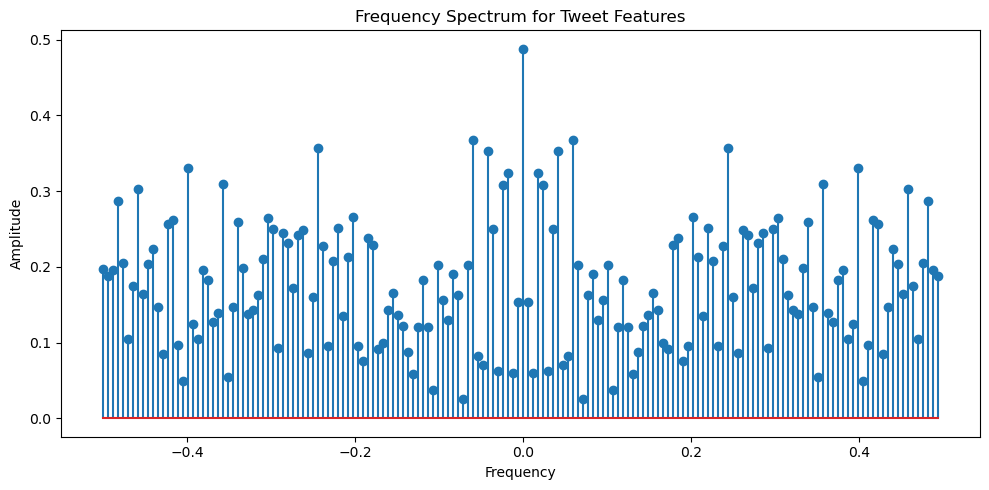

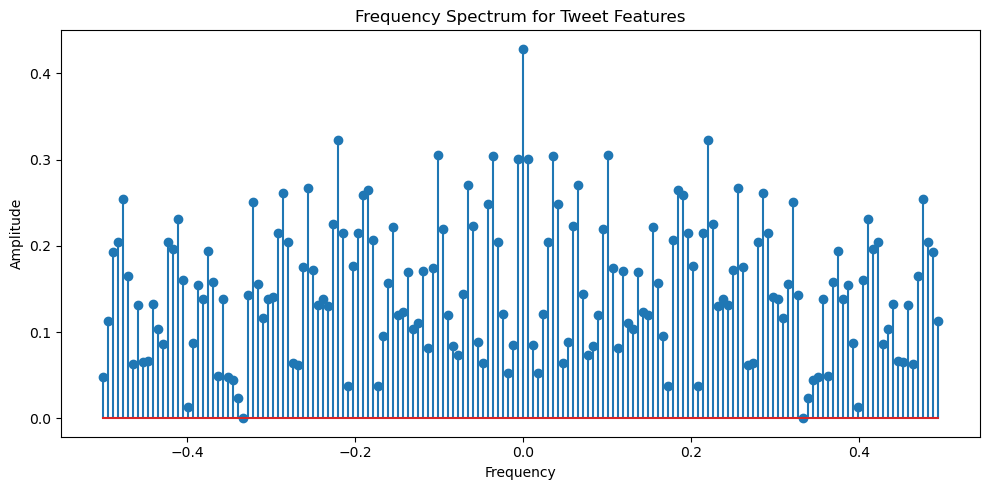

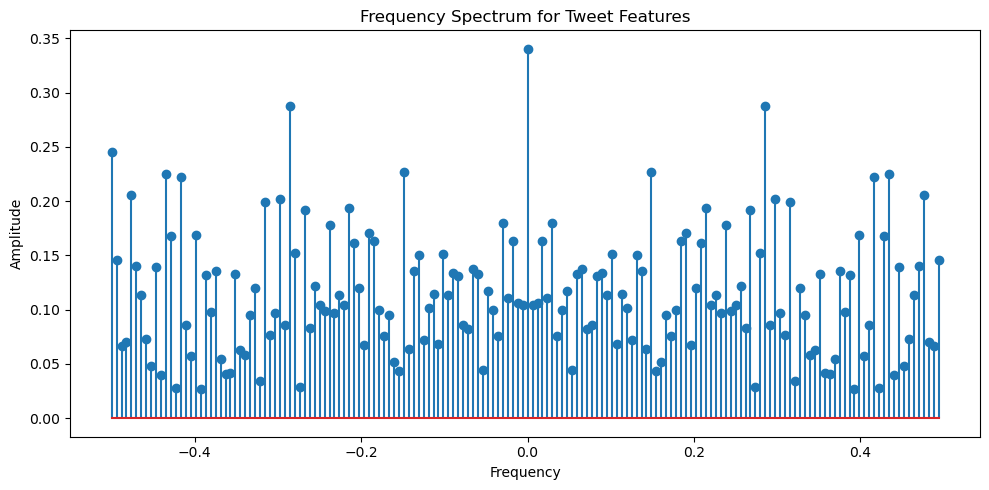

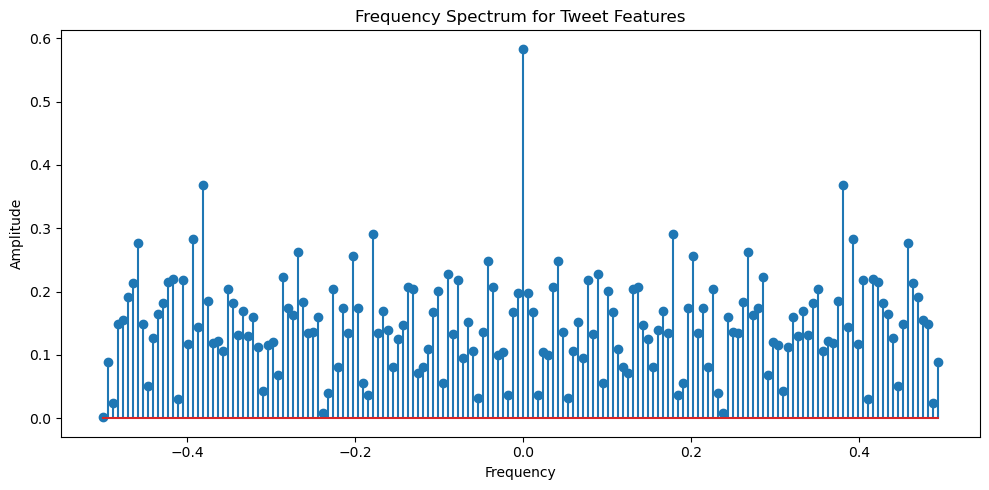

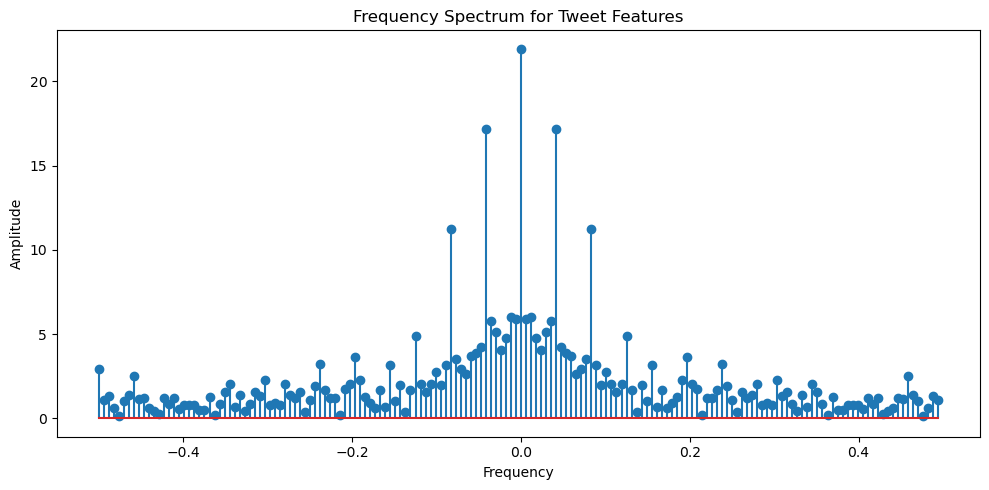

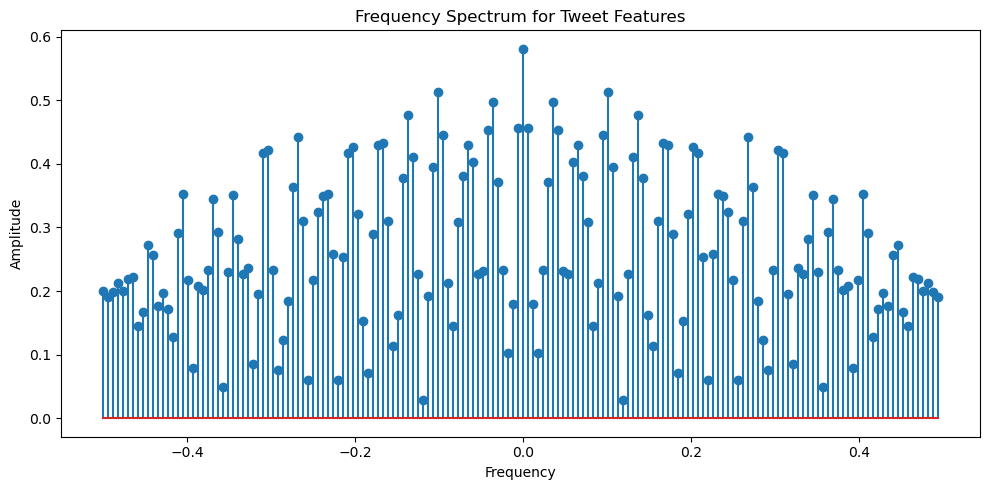

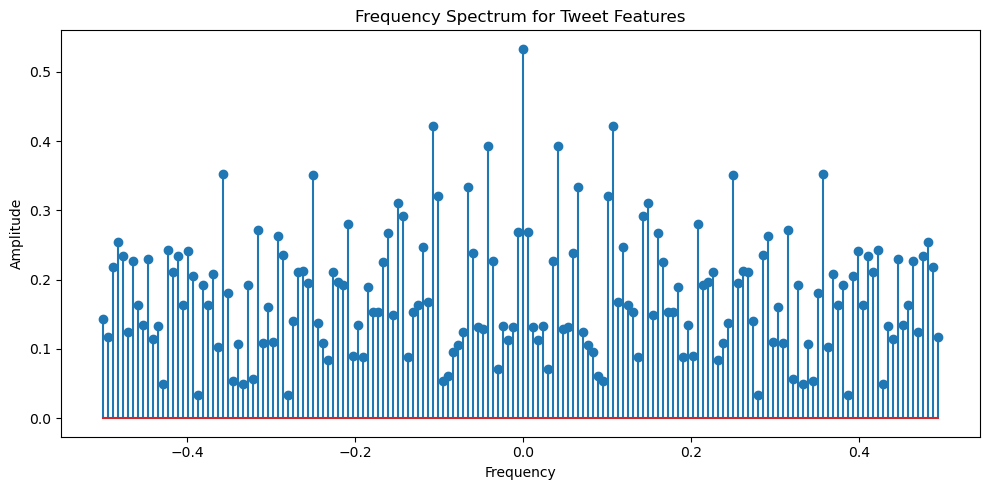

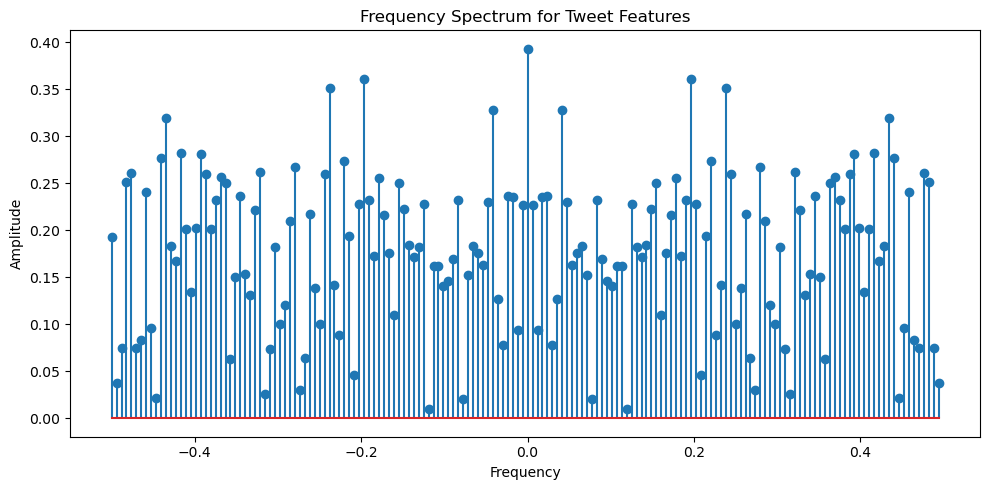

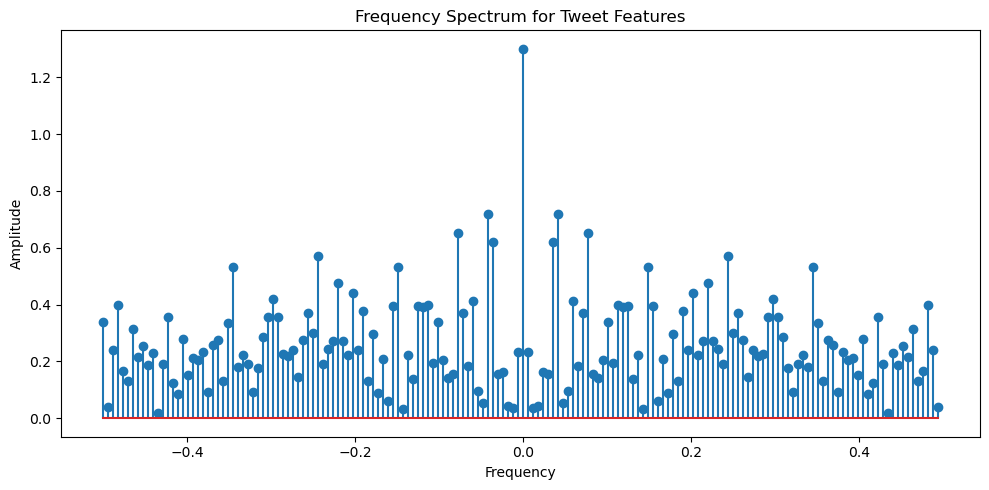

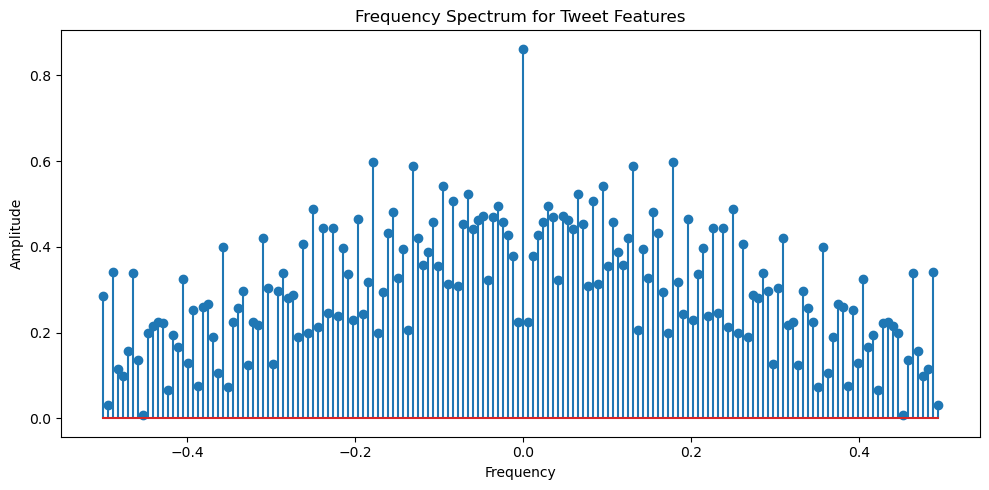

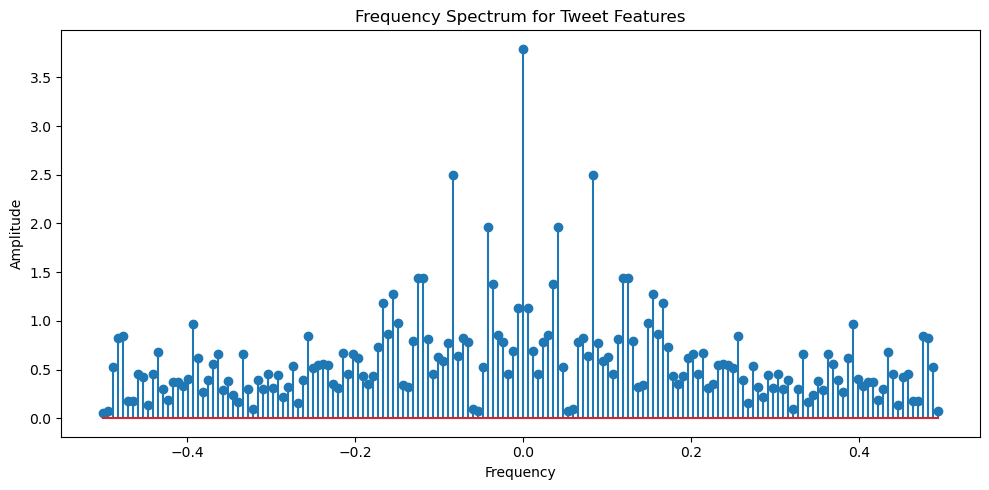

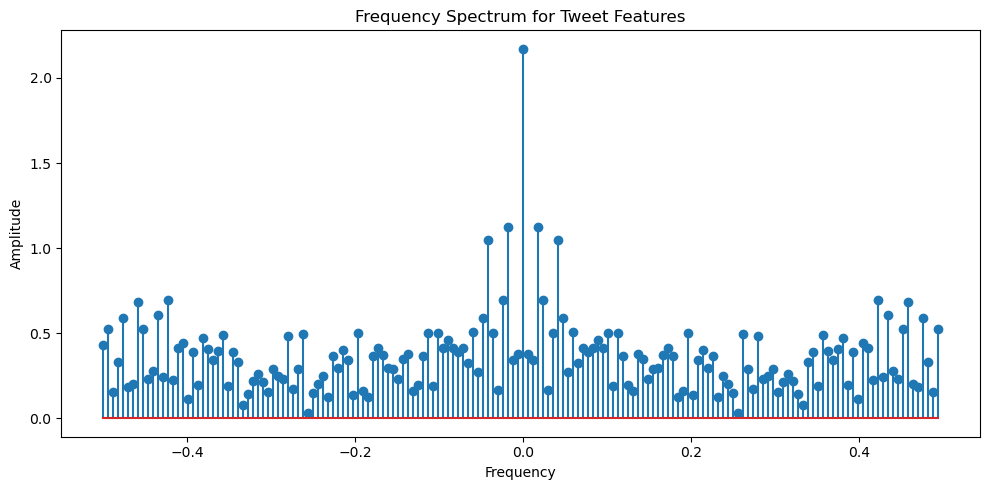

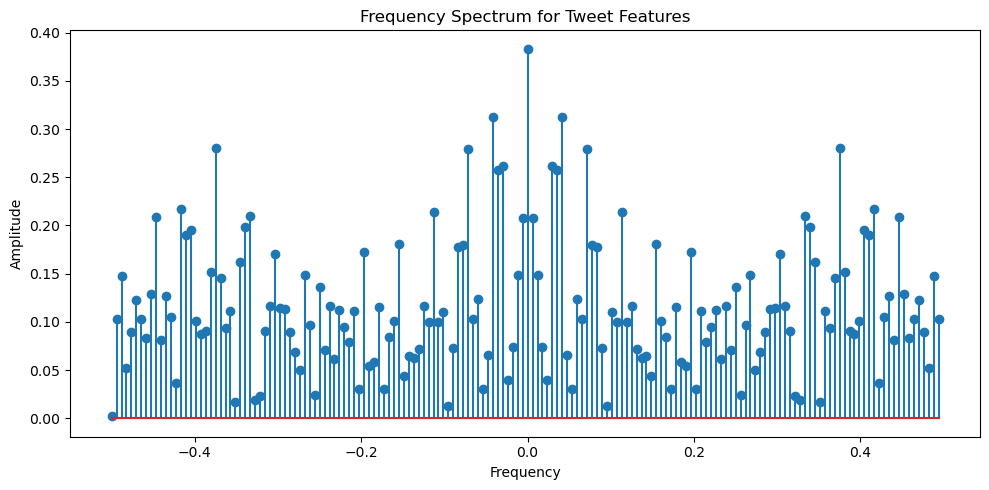

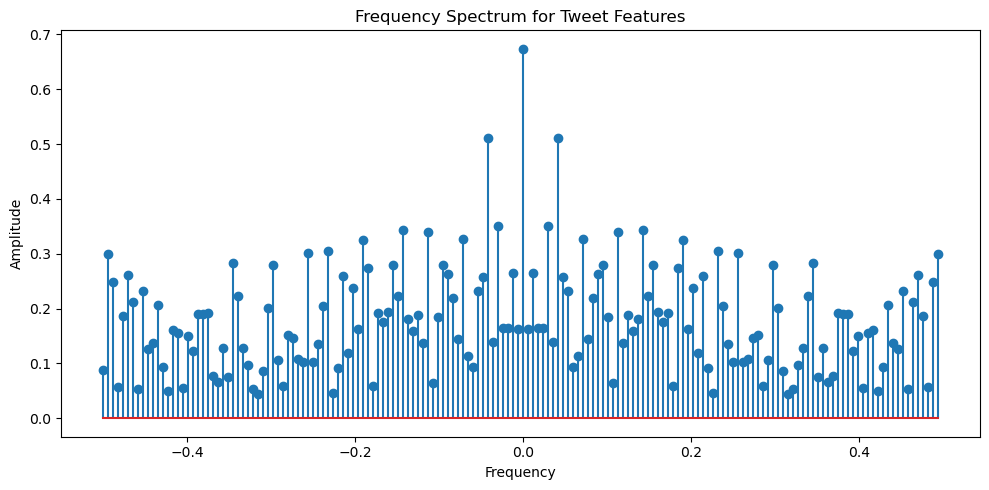

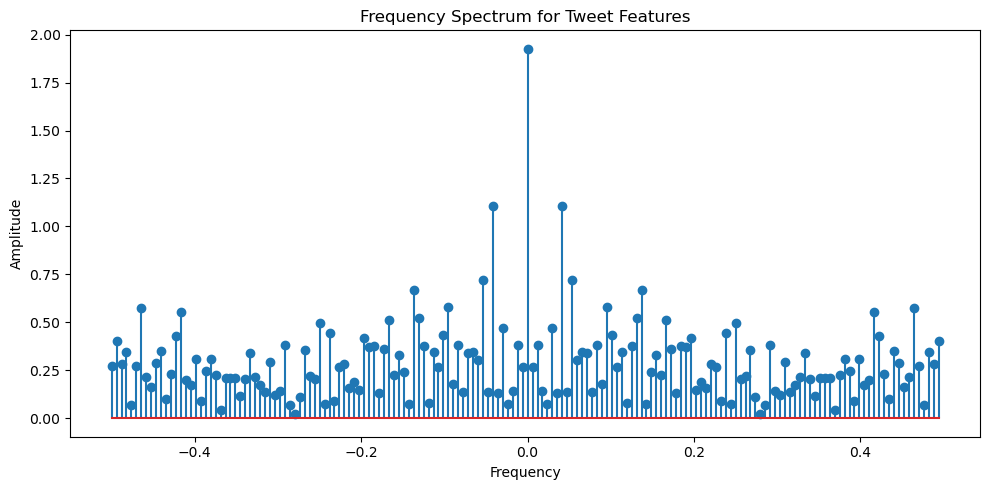

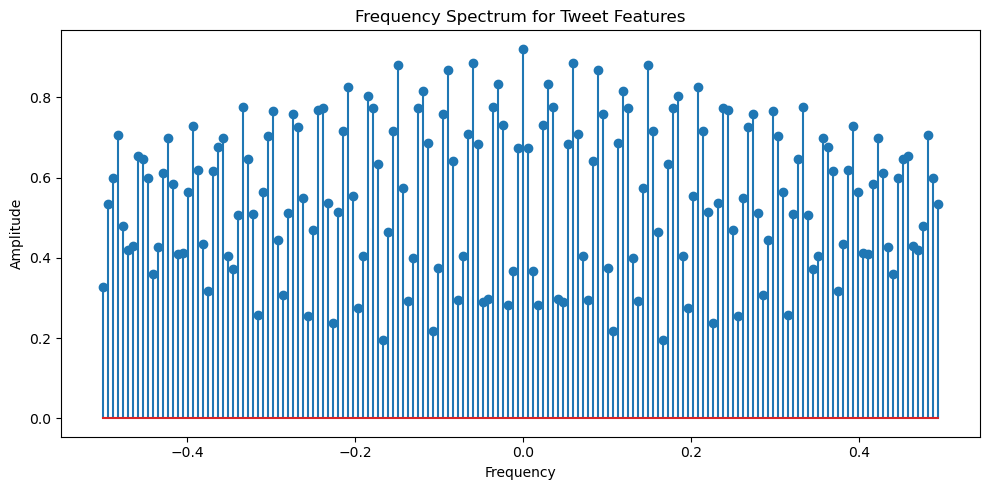

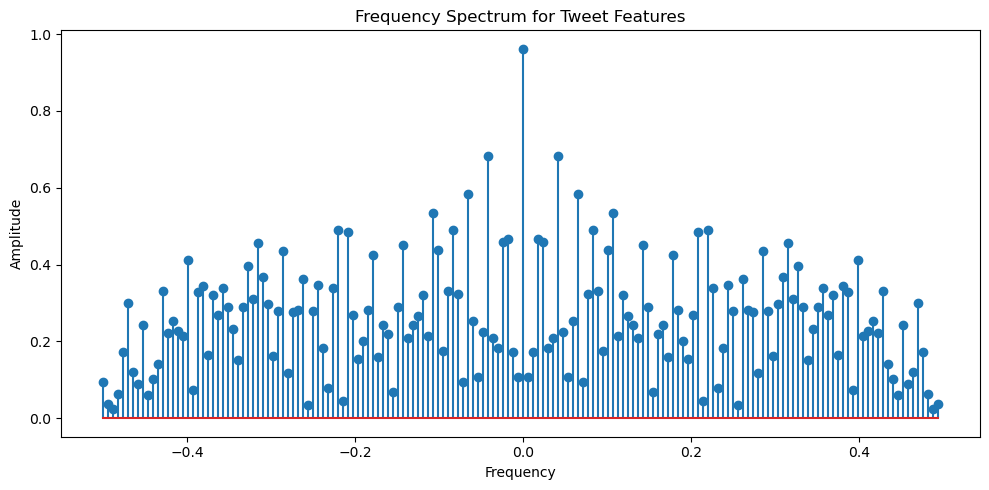

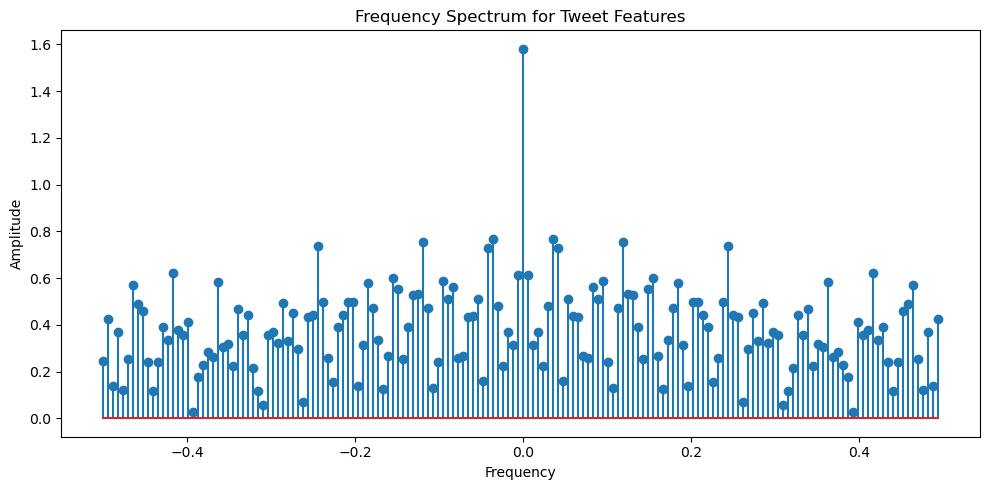

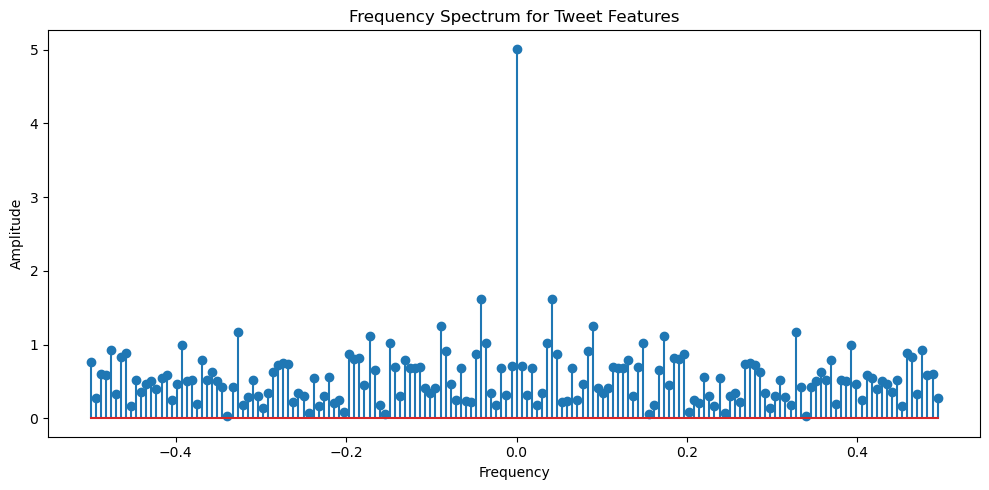

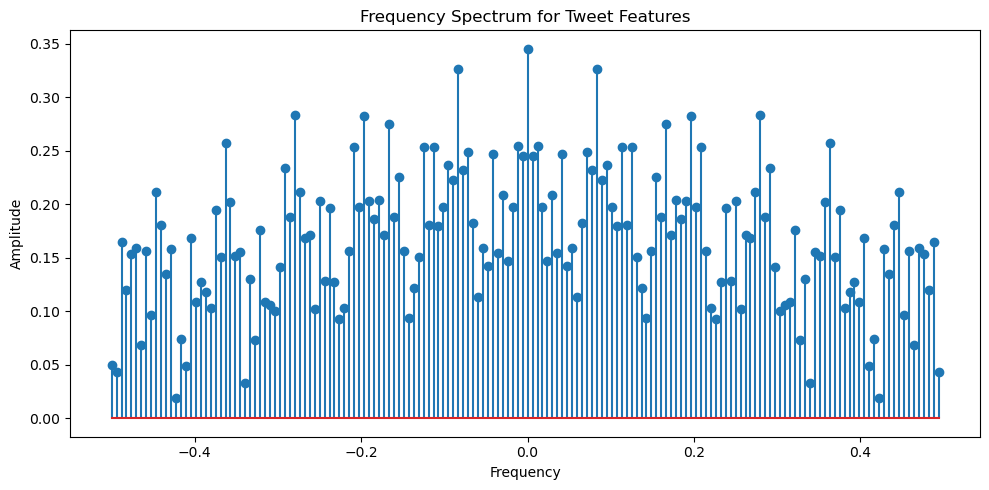

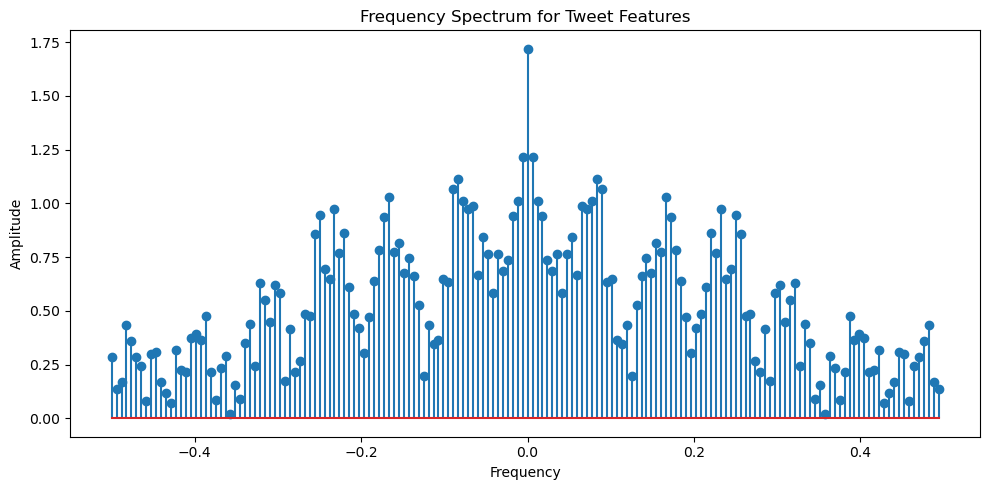

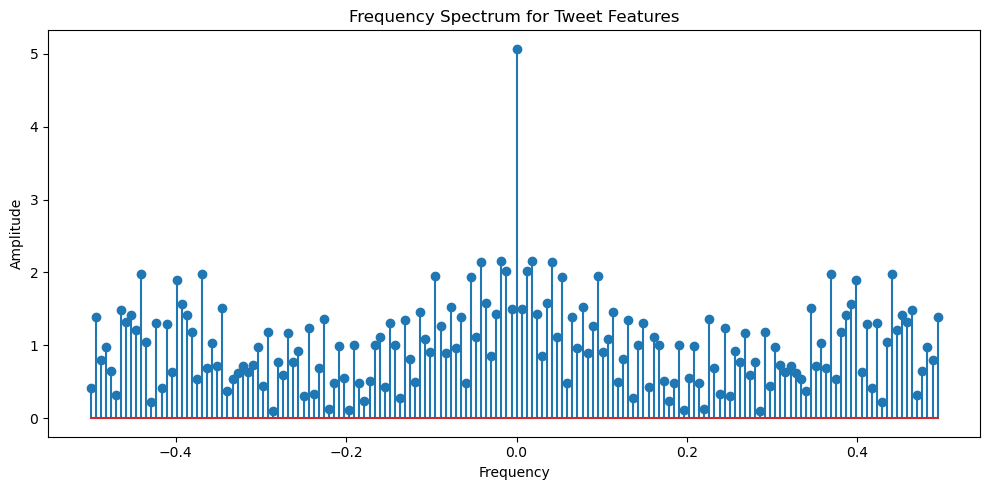

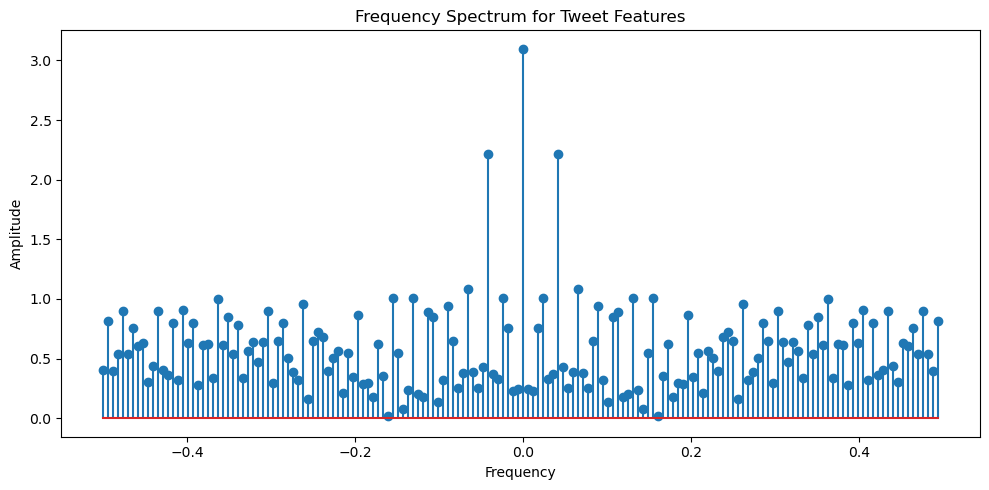

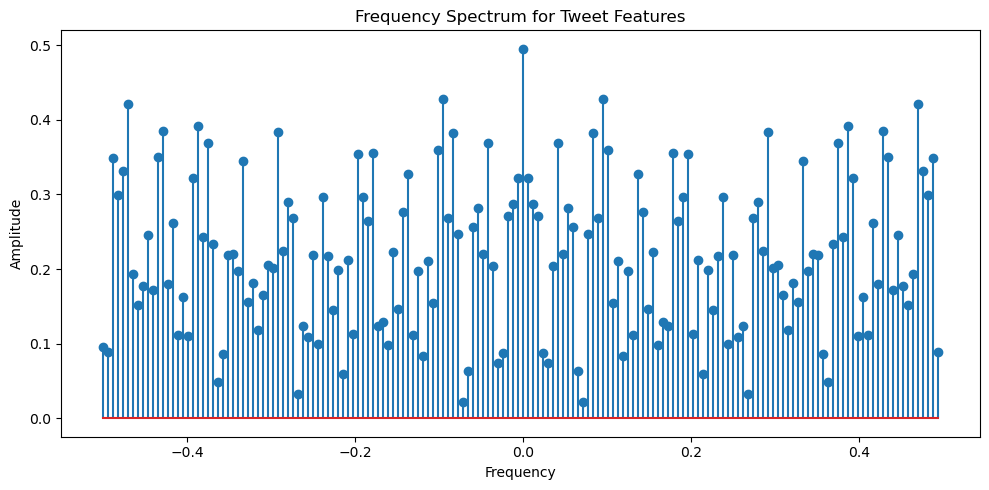

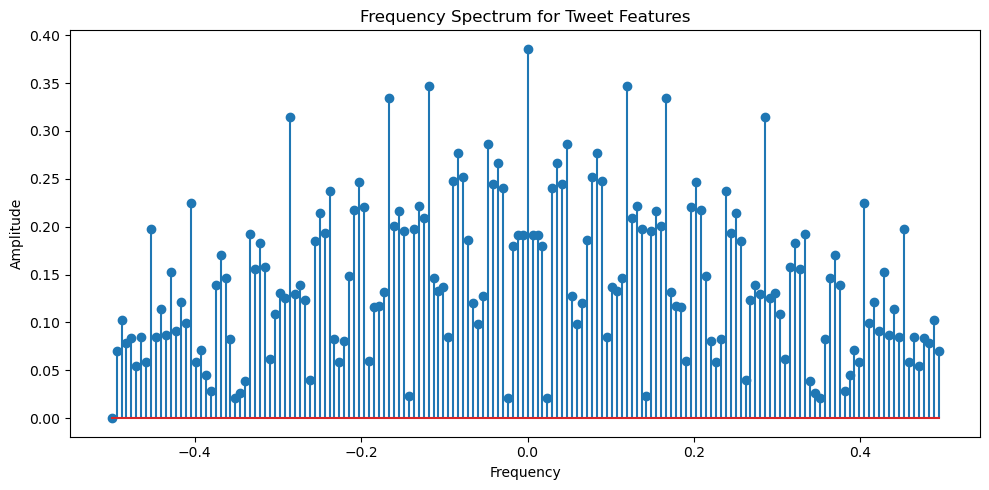

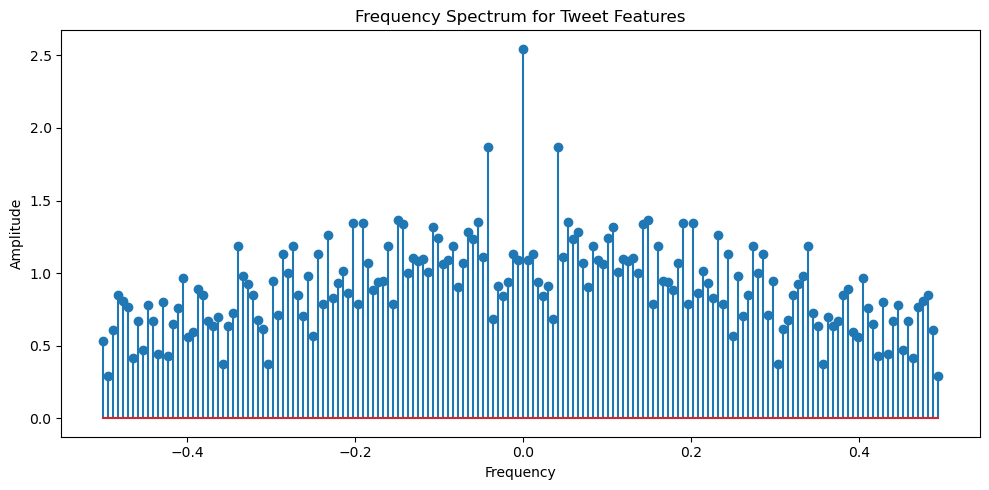

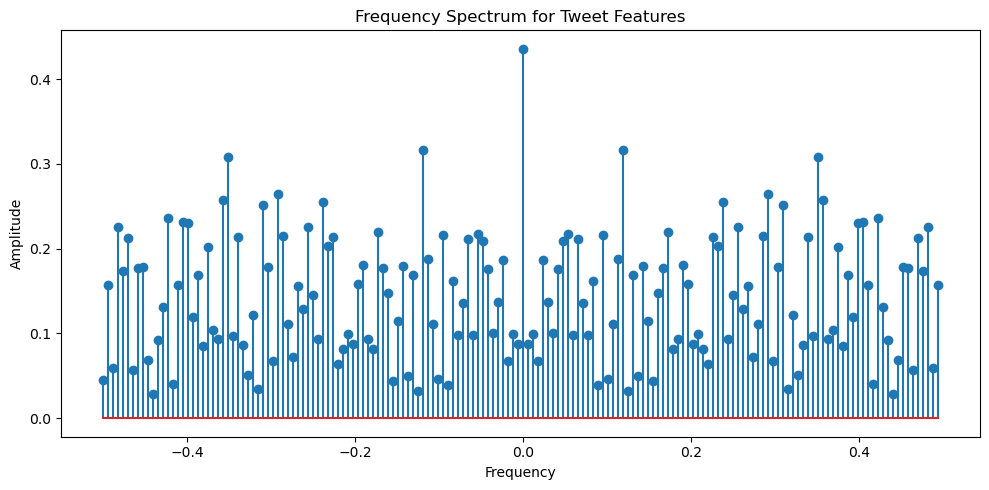

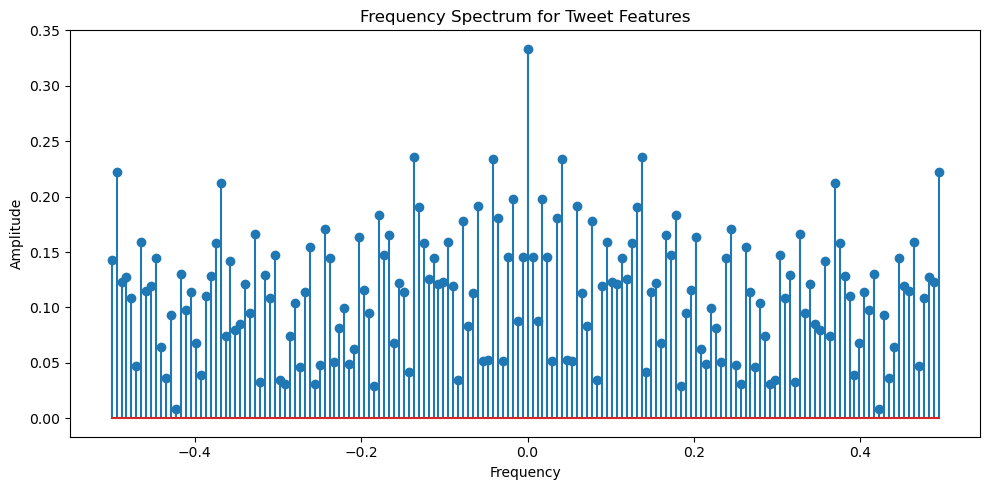

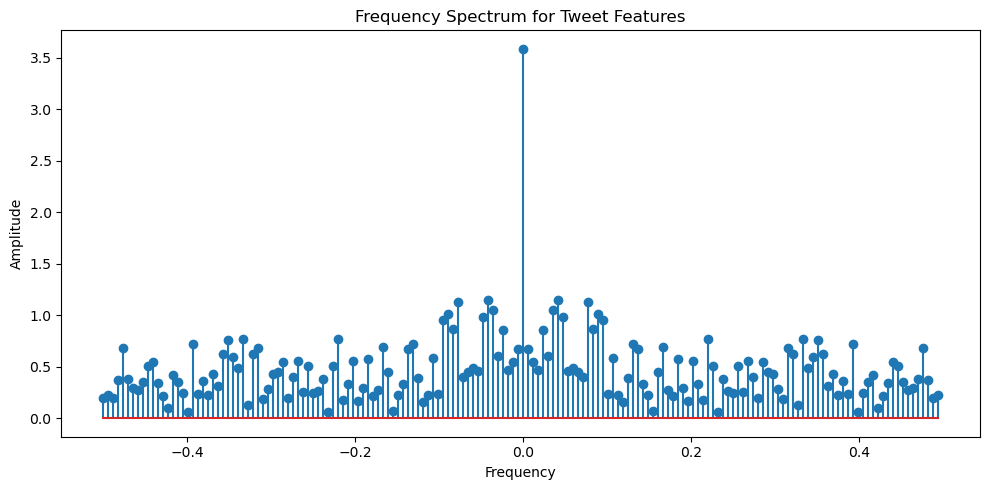

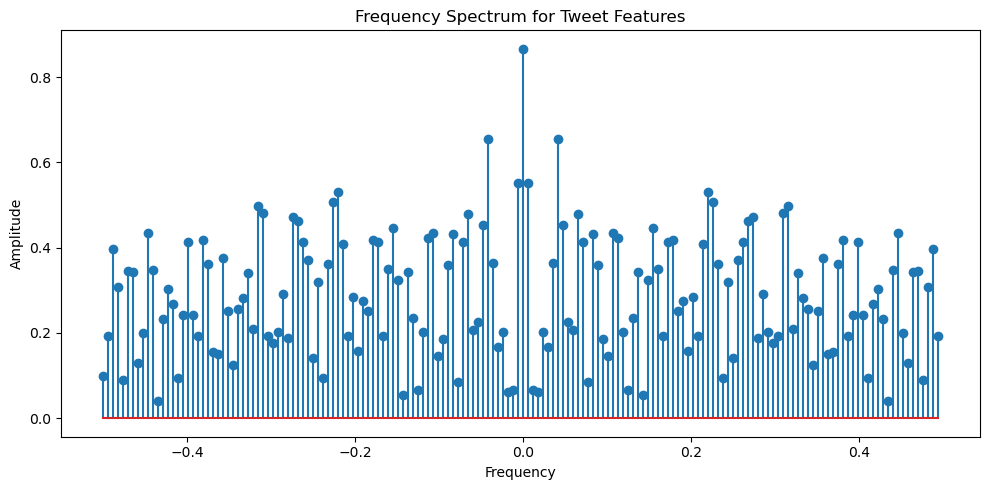

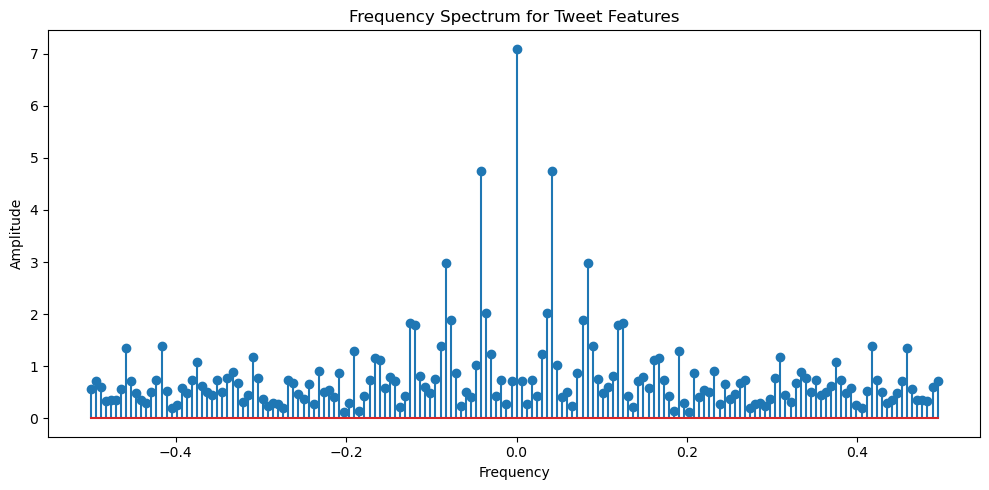

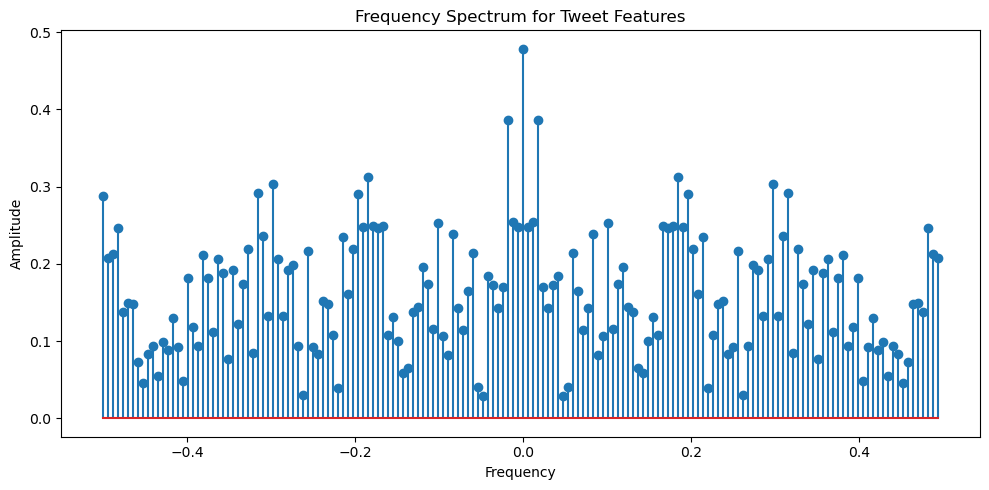

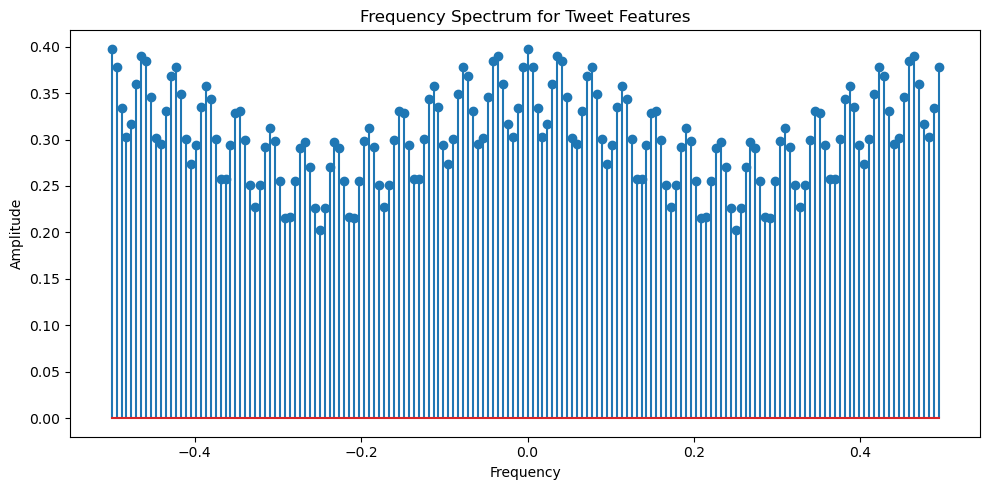

KeyboardInterrupt: 

In [108]:
def apply_fft(row, num_frequencies=1):
    # Perform FFT
    fft_vals = np.fft.fft(row)
    plt.figure(figsize=(10, 5))
    frequencies = np.fft.fftfreq(len(row))
    plt.stem(frequencies, np.abs(fft_vals))
    plt.title('Frequency Spectrum for Tweet Features')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()
    # Get indices of the highest magnitudes
    indices = np.argsort(np.abs(fft_vals))[-num_frequencies:]
    # Return the magnitudes of the selected frequencies
    return np.abs(fft_vals[indices])

# Apply FFT to all rows and create a consistent feature set
transformed_data = np.array([apply_fft(row) for index, row in tweet_features.iterrows()])
transformed_data

c:\Users\lenovo\anaconda3\envs\spatial\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lenovo\anaconda3\envs\spatial\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(
c:\Users\lenovo\anaconda3\envs\spatial\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lenovo\anaconda3\envs\spatial\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known 

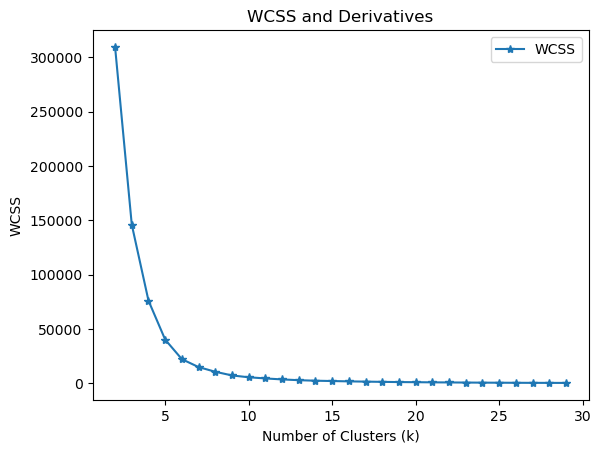

In [67]:
# List of k values
k_values = range(2, 30)

# List of withinss values
withinss_values = []

# Calculate withinss for each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k)

    kmeans.fit(transformed_data)
    withinss_values.append(kmeans.inertia_)

# Assume withinss_values are the previously calculated WCSS data
withinss_values = np.array(withinss_values)  # Make sure this is a NumPy array

# Calculate the first derivative
first_derivative = np.diff(withinss_values) / np.diff(k_values)

# Calculate the second derivative
second_derivative = np.diff(first_derivative) / np.diff(k_values[:-1])  # Note that the length of k_values is reduced by one

# Plot the original data and the derivatives
plt.plot(k_values, withinss_values, '*-', label='WCSS')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('WCSS and Derivatives')
plt.legend()
plt.show()

c:\Users\lenovo\anaconda3\envs\spatial\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lenovo\anaconda3\envs\spatial\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(
C:\Users\lenovo\AppData\Local\Temp\ipykernel_17060\3831411425.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

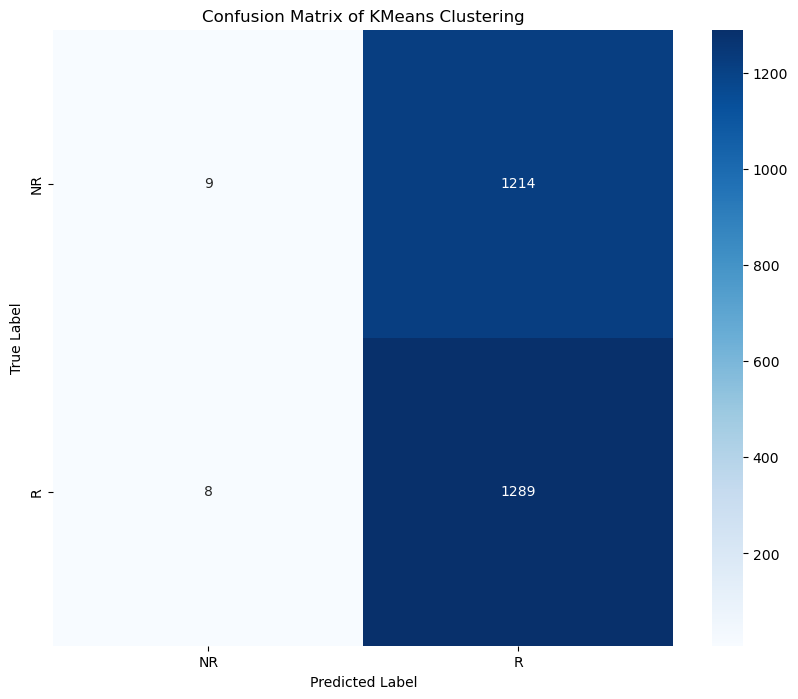

Classification Report:
               precision    recall  f1-score   support

          NR       0.53      0.01      0.01      1223
           R       0.51      0.99      0.68      1297

    accuracy                           0.52      2520
   macro avg       0.52      0.50      0.35      2520
weighted avg       0.52      0.52      0.36      2520



In [68]:

from scipy.stats import mode
# Fit the KMeans model
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(transformed_data)

# Predict the cluster labels
predicted_labels = kmeans.predict(transformed_data)

# Map the predicted cluster labels to the true labels
label_mapping = {}
for cluster_id in set(predicted_labels):
    # Indices of rows in this cluster
    cluster_indices = predicted_labels == cluster_id
    # True labels of rows in this cluster
    real_labels = data.loc[cluster_indices, 'label']
    # Most common true label in this cluster
    most_common_label = mode(real_labels).mode[0]
    # Map cluster ID to the most common true label
    label_mapping[cluster_id] = most_common_label

# Apply the mapping
mapped_predicted_labels = pd.Series(predicted_labels).map(label_mapping)

# Compute the confusion matrix
conf_matrix = confusion_matrix(data['label'], mapped_predicted_labels)
class_report = classification_report(data['label'], mapped_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(data['label']), 
            yticklabels=np.unique(data['label']))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of KMeans Clustering')
plt.show()

# Print the classification report
print("Classification Report:\n", class_report)

In [52]:
# Now, use K-Means
kmeans = KMeans(n_clusters=6)
kmeans.fit(transformed_data)

# Get cluster labels
cluster_labels = kmeans.labels_
cluster_labels

c:\Users\lenovo\anaconda3\envs\spatial\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\lenovo\anaconda3\envs\spatial\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


array([0, 0, 0, ..., 0, 0, 3])